# Import Libraries

In [16]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load model and selector

In [17]:

# Load model and selector
model = joblib.load('best_models/random_forest_model.pkl')
selector = joblib.load('best_models/random_forest_rfe_selector.pkl')

# Test across 20 datasets

In [18]:
# Store metrics
f1_scores = []
accuracy_1_scores = []
accuracy_2_scores = []

for i in range(1, 21):
    path = f"../../data/split_{i}.csv"

    # Load data
    test = pd.read_csv(path)
    y_test = test['Severity']
    X_test = test.drop(columns=['Severity'])

    # Apply feature selection
    X_test_selected = selector.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_selected)

    # Metric 1: Weighted F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

    # Metric 2: Accuracy1 (Exact match)
    acc1 = np.mean(y_pred == y_test)
    accuracy_1_scores.append(acc1)

    # Metric 3: Accuracy2 (±1 of true label)
    acc2 = np.mean(np.abs(y_pred - y_test) <= 1)
    accuracy_2_scores.append(acc2)

    print(f"Dataset {i:02d} - F1: {f1:.4f} | Accuracy1: {acc1:.4f} | Accuracy2: {acc2:.4f}")


Dataset 01 - F1: 0.6310 | Accuracy1: 0.5480 | Accuracy2: 0.7790
Dataset 02 - F1: 0.6189 | Accuracy1: 0.5230 | Accuracy2: 0.7390
Dataset 03 - F1: 0.6554 | Accuracy1: 0.5620 | Accuracy2: 0.7690
Dataset 04 - F1: 0.6072 | Accuracy1: 0.5140 | Accuracy2: 0.7270
Dataset 05 - F1: 0.6361 | Accuracy1: 0.5440 | Accuracy2: 0.7660
Dataset 06 - F1: 0.6283 | Accuracy1: 0.5430 | Accuracy2: 0.7560
Dataset 07 - F1: 0.6242 | Accuracy1: 0.5200 | Accuracy2: 0.7390
Dataset 08 - F1: 0.6083 | Accuracy1: 0.5110 | Accuracy2: 0.7570
Dataset 09 - F1: 0.6193 | Accuracy1: 0.5310 | Accuracy2: 0.7540
Dataset 10 - F1: 0.6201 | Accuracy1: 0.5280 | Accuracy2: 0.7370
Dataset 11 - F1: 0.6301 | Accuracy1: 0.5390 | Accuracy2: 0.7780
Dataset 12 - F1: 0.6159 | Accuracy1: 0.5250 | Accuracy2: 0.7640
Dataset 13 - F1: 0.6210 | Accuracy1: 0.5190 | Accuracy2: 0.7580
Dataset 14 - F1: 0.6115 | Accuracy1: 0.5170 | Accuracy2: 0.7300
Dataset 15 - F1: 0.6034 | Accuracy1: 0.5050 | Accuracy2: 0.7350
Dataset 16 - F1: 0.6154 | Accuracy1: 0.5

In [19]:
# Convert lists to arrays
f1_scores = np.array(f1_scores)
accuracy_1_scores = np.array(accuracy_1_scores)
accuracy_2_scores = np.array(accuracy_2_scores)


# Plot mean & std

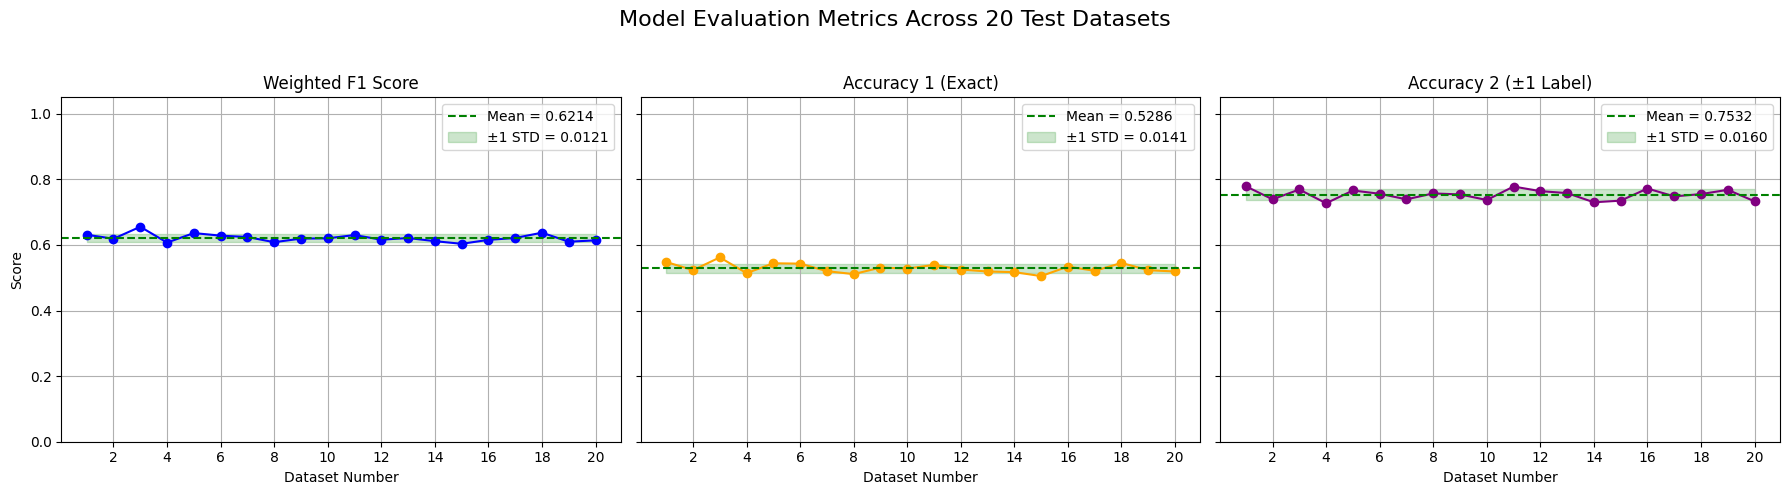

In [20]:


# Plotting: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

metrics = [f1_scores, accuracy_1_scores, accuracy_2_scores]
titles = ['Weighted F1 Score', 'Accuracy 1 (Exact)', 'Accuracy 2 (±1 Label)']
colors = ['blue', 'orange', 'purple']

for i in range(3):
    axs[i].plot(range(1, 21), metrics[i], marker='o', color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Dataset Number")
    axs[i].set_xticks(range(2, 21, 2))  # Show only even-numbered ticks
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(True)

    mean_score = np.mean(metrics[i])
    std_dev = np.std(metrics[i])
    axs[i].axhline(mean_score, color='green', linestyle='--', label=f'Mean = {mean_score:.4f}')
    axs[i].fill_between(range(1, 21),
                        mean_score - std_dev,
                        mean_score + std_dev,
                        color='green', alpha=0.2,
                        label=f'±1 STD = {std_dev:.4f}')
    axs[i].legend()


axs[0].set_ylabel("Score")
plt.suptitle("Model Evaluation Metrics Across 20 Test Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Mostly flat lines -> stable

# Coefficient of Variation (CV)
This tells you how large the std dev is relative to the mean

Rule of thumb used:

- CV < 0.1 = very stable
- CV 0.1–0.2 = moderate variation
- CV > 0.2 = potentially unstable

In [21]:
cv_f1 = np.std(f1_scores) / np.mean(f1_scores)
cv_acc1 = np.std(accuracy_1_scores) / np.mean(accuracy_1_scores)
cv_acc2 = np.std(accuracy_2_scores) / np.mean(accuracy_2_scores)

print(f"CV Weighted F1 Score: {cv_f1:.4f}")
print(f"CV Accuracy 1: {cv_acc1:.4f}")
print(f"CV Accuracy 2: {cv_acc2:.4f}")

CV Weighted F1 Score: 0.0194
CV Accuracy 1: 0.0266
CV Accuracy 2: 0.0212


# Save metrics to CSV

To compare between models later

In [22]:
# Model identifier
model_name = 'random_forest'  # or 'neural_networks', 'svm', 'ordinalgbt'.

# Create DataFrame
df_metrics = pd.DataFrame({
    'model': model_name,
    'dataset': range(1, 21),
    'weighted_f1_score': f1_scores,
    'accuracy_1': accuracy_1_scores,
    'accuracy_2': accuracy_2_scores
})

# Append to a master CSV (one file for all models)
csv_path = "../../metrics/model_performance_across_20k_datasets.csv"

# Save: use mode='a' to append if the file exists, and header=False to avoid duplicating headers
try:
    existing = pd.read_csv(csv_path)
    df_metrics.to_csv(csv_path, mode='a', index=False, header=False)
except FileNotFoundError:
    df_metrics.to_csv(csv_path, index=False)

# Test for normal distribution

For paired t-test later in best_model.ipynb

- p-value < 0.05: Reject the null hypothesis (the data is not normally distributed).
- p-value ≥ 0.05: Fail to reject the null hypothesis (the data is normally distributed).

In [23]:
from scipy.stats import shapiro

stat, p = shapiro(f1_scores)
print(f"Shapiro-Wilk Test: Stat={stat:.3f}, p-value={p:.4f}")

Shapiro-Wilk Test: Stat=0.938, p-value=0.2162
